## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


<b>AB testing</b>: is a type of experimentation that helps to compare two different versions of a web page to check which one has more clicks or visitors. 

<b>Project</b>: I have to understand the A/B results of an e-commerce website.
<br>
The company developed a new web page to increase the number of users who "convert"; I mean the number of users who decide to pay for the company's product.
<br>
So in this notebook I want to help the company to understand if they should:
<ol>
    <li>implement this new page.</li>
    <li>keep the old page.</li>
    <li>or run the experiment longer to make their decision.</li>
</ol>
<br>
<b>What I have to use?</b>
<br>
Jupyter Notebook with a Python 3 (pandas, numpy, matplotlib and statsmodels).


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
len(df.index)

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
# get the mean directly via using the mean
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
x1=len(df.query('group!="treatment" and landing_page=="new_page"'))
x2=len(df.query('group!="control" and landing_page=="old_page"'))
x=x1+x2
print(x)

3893


f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=df
df2=df[((df.group == 'treatment') & (df.landing_page=='new_page')) | ((df.group == 'control') & (df.landing_page=='old_page'))]
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

<p>as the result is 0 so the required is done.</p>

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [9]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [10]:
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [11]:
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
# remove duplicated row
df2=df2.drop_duplicates()
# make sure that row is removed
sum(df2.duplicated())

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [13]:
df2['converted'].mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880724790277405

d. What is the probability that an individual received the new page?

In [16]:
len(df2.query('landing_page == "new_page"'))/len(df2.index)

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Regarding to the results I got, we can summarize the result as follow:
The number of indivisuals who converted was approximately equal to 12% for each group, so there is no a powerful evidence that the new treatment page will lead to more conversions.**

**Add for that, that is the probability that an individual received the new page is equal to 0.5 !.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

<b>**$H_{0} :$** **$p_{old}$** **$>=$** **$p_{new}$**</b>
<br/>
<b>**$H_{1} :$** **$p_{old}$** **$<$** **$p_{new}$**</b>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [17]:
p_new=df2.converted.mean()
print(p_new)

0.119596675671


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [18]:
p_old=df2.converted.mean()
print(p_old)

0.119596675671


c. What is $n_{new}$, the number of individuals in the treatment group?

In [19]:
n_new=df2.query("group == 'treatment'").shape[0]
print(n_new)

145311


d. What is $n_{old}$, the number of individuals in the control group?

In [20]:
n_old=df2.query("group == 'control'").shape[0]
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [21]:
new_page_converted=np.random.choice([0,1],n_new,p=[p_new,1-p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [22]:
old_page_converted=np.random.choice([0,1],n_old,p=[p_old,1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [23]:
diff=new_page_converted.mean()-old_page_converted.mean()
print(diff)

0.000126830335746


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [24]:
p_diffs=[]
for i in range (10000):
    new_page_converted=np.random.choice([0,1],n_new,p=[p_new,1-p_new]).mean()
    old_page_converted=np.random.choice([0,1],n_old,p=[p_old,1-p_old]).mean()
    p_diffs.append(new_page_converted-old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5,1,'Histogram of the p_diffs')

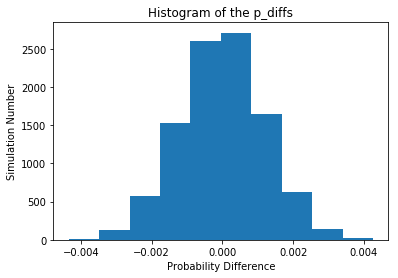

In [25]:
plt.hist(p_diffs)
plt.ylabel("Simulation Number")
plt.xlabel("Probability Difference")
plt.title("Histogram of the p_diffs")

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [26]:
M1=df2[df2['landing_page'] == 'new_page']
M1=M1['converted'].mean()
M2=df2[df2['landing_page'] == 'old_page']
M2=M2['converted'].mean()
actual_difference=M1-M2
counter=0
for i in p_diffs:
    if i>actual_difference:
        counter=counter+1
print(counter/len(p_diffs))

0.908


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Regarding to the previous part I calculated the p-value; the rejecting null value must be <= the alpha; where alpha is =0.05 , and here it equals to 0.908, it is >0.05 ; as a result the new page was not doing significantly better than the old page, old page is better than the new page. so we will not reject the null hypothesis .**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [40]:
import statsmodels.api as sm

convert_old = len(df2.query('converted==1 and landing_page=="old_page"'))
convert_new = len(df2.query('converted==1 and landing_page=="new_page"'))
n_old = len(df2.query('landing_page=="old_page"'))
n_new = len(df2.query('landing_page=="new_page"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [28]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3116075339133115, 0.90517370514059103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**z-score: it is computed in the previuos part and it was equal to 1.311; in reference to the 95% confidence interval (1.96), there is no statistical evidence to reject the null hypothesis.
for p-score: it agrees with the findings in parts j and k; it fails to reject the null hypothesis as it provides evdience of a higher probability of the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2['intercept']=1
df2[['ab_page_2','ab_page']]=pd.get_dummies(df2['group'])
df2=df2.drop('ab_page_2',axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [36]:
stats_model=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result=stats_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Nov 2019   Pseudo R-squ.:               8.085e-06
Time:                        08:24:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**From the p-value associated with ab_page it equals to 0.19, note that it is 0.908 in Part II;
<br/>
for part II:
<br/>
<b>**$H_{0} :$** **$p_{old}$** **$>=$** **$p_{new}$**</b>
<br/>
<b>**$H_{1} :$** **$p_{old}$** **$<$** **$p_{new}$**</b>
<br/>
for this part, logistic:
<br/>
<b>**$H_{0} :$** **$p_{old}$** **$=$** **$p_{new}$**</b>
<br/>
<b>**$H_{1} :$** **$p_{old}$** **$\ne$** **$p_{new}$**</b>
<br/>
so we have different hypothesis used for the these parts.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Advantages:**
It can be used to find the outliers, and it can influence the indivisual converts.

**Disadvantages:**
May it generate inaccurate results because of correlated errors; we don't know  in which trend it will influence the results.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
df_countries=pd.read_csv('countries.csv')
# inner join for data sets
df_new=df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [43]:
# in reference to the Hint: You will need two columns for the three dummy variables
df_new[['US','UK']]=pd.get_dummies(df_new['country'])[['US','UK']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0


In [44]:
df_new['ab_page_US']=df_new['US']*df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,ab_page_US
user_id,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0,1


In [45]:
df_new['ab_page_UK']=df_new['UK']*df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,ab_page_US,ab_page_UK
user_id,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0,1,0


In [49]:
logit_part=sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','UK','ab_page_US','ab_page_UK']])
logit_part

In [52]:
logit_part_result=logit_part.fit()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [53]:
logit_part_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Tue, 26 Nov 2019   Pseudo R-squ.:               3.483e-05
Time:                        09:23:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1918
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
ab_page_US     0.0469      0.054      0.872      0.383      -0.059       0.152
ab_page_UK     0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

note that p-value still higher than alpha, so fail to reject null.

<a id='conclusions'></a>
**Conclusions**
<p>
as we saw that no variables have significant p-values; we failed to reject the null hypothesis in the bothparts; Part II and Part III, and there is no a powerful evidence that there is an interaction between country and page received which enhance the prediction whether a user converts or not, I mean no evidence that the new page cause more conversions than the old page.    
</p>